In [1]:
import numpy as np
import matplotlib.pyplot as plt
from structgeo.model import geo
from structgeo.model import plot as geovis
from structgeo.model import history as geohistory

import pyvista as pv
# Static plots:
pv.set_jupyter_backend('static')
# Dynamic plots:
# pv.set_jupyter_backend('trame')
# pv.set_jupyter_backend('html')


## GeoModel
The GeoModel class provides the framework to construct 3D geological models from a defined sequence of GeoProcesses.

- **Flexible Grid Definition**: Define your grid by specifying bounds. Provide a single min/max tuple for a cubic grid or distinct min/max tuples for each axis to create a rectangular prism.
- **Adjustable Resolution**: Control the granularity of the grid with the resolution parameter, which sets the number of divisions along each axis.
- **Data Type**: Optimize memory usage and computation speed by specifying the data type of the grid values, with np.float32 as the default

In [2]:
# Cubic model
bounds = (-10, 10)
resolution = 128
model = geo.GeoModel(bounds=bounds, resolution=resolution)

# Alternatively, you can specify different bounds for each axis
bounds = ((-20, 20), (-20, 20), (-10, 10))
model = geo.GeoModel(bounds=bounds, resolution=resolution)

## GeoProcess

GeoProcess is a base class for modeling geological events in the GeoModel framework. 

#### Frame Convention: 
North corresponds to the positive x-axis; transformations consider this orientation for applying modifications like strike and dip. Strike is measured from the north in a clockwise direction, and dip is the angle from the horizontal plane. The north direction is set as the positive y-axis as convention in 2D maps

There are two types of geological modifications: Depositions and Transformations

#### Depositions:
These processes add or remove geological materials (e.g., rock layers, dikes) to the model without changing the spatial coordinates of the mesh.

Examples:

**Layer**: Adds horizontal layers of material, defined by a base, width, and material value.

**Dike**: Inserts a vertical or angled planar feature defined by strike, dip, and width.

**Sedimentation**: Simulates the accumulation of sediment layers, where each layer's thickness can be randomly determined.

#### Transformations:
These processes alter the geometry of the mesh (the spatial coordinates) to simulate geological forces, without changing the properties assigned to the mesh points.

Examples:

**Fold**: Deforms the mesh to create a fold structure, defined by a wavelength, amplitude, and orientation.

**Fault**: Displaces the mesh along a planar surface, defined by strike, dip, and offset.

#### Building Geological History:
A list of GeoProcesses can be added to a GeoModel to build up a history of events. Once a full history is defined, the model can be computed to visualize the cumulative effects of the geological processes.

History Management: Add one or more events to the history using the add history method. The order of the events in the history list determines the sequence in which they are applied to the model. To clear the history use the clear history method. This will remove all events from the history list but not change the model until it is recomputed.

In [3]:
# Bedrock forms the basement layer of the model.  
bedrock = geo.Bedrock(base=-5, value=1)

# Sedimentation is a layer of sedimentary rock that is deposited until reaching a fixed height.
# Sedimentation takes a list of values that represent different types of sedimentary rocks.
# The thickness of eac
sediment0 = geo.Sedimentation(height=0, 
                              value_list=range(1, 5), 
                              )

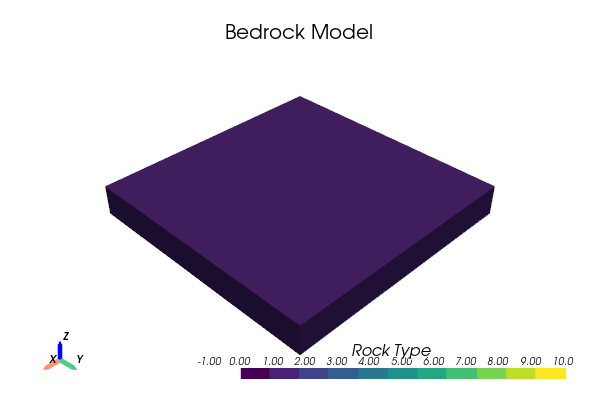

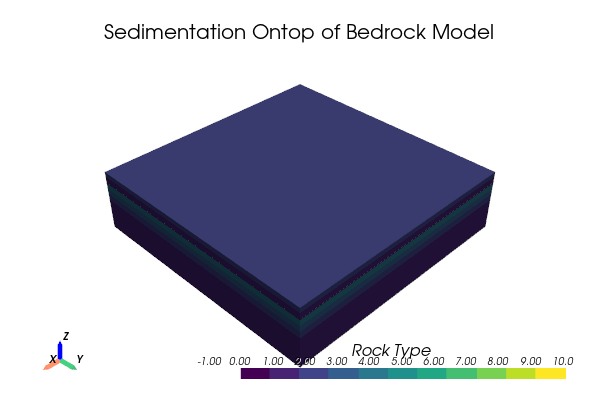

In [4]:
model.clear_history()
# Add a base layer of bedrock
model.add_history(bedrock)
model.compute_model()
p = geovis.volview(model)

window_size = (600, 400)

p.window_size = window_size
p.add_title(title='Bedrock Model', font_size=8)
p.show()

model.add_history(sediment0)
model.compute_model()
p2 = geovis.volview(model)
p2.window_size = window_size
p2.add_title(title='Sedimentation Ontop of Bedrock Model', font_size=8)
p2.show()


### Sedimentation
The process can accept a list of rocktypes to select from. The default is to cycle through the list. Since the number of layers is not known until model build time, thicknesses must be generated at that time with a generator. Default thickness is 1.0 if no generator is provided.

To change the default behaviour, a rocktype list and a selector function can be passed:

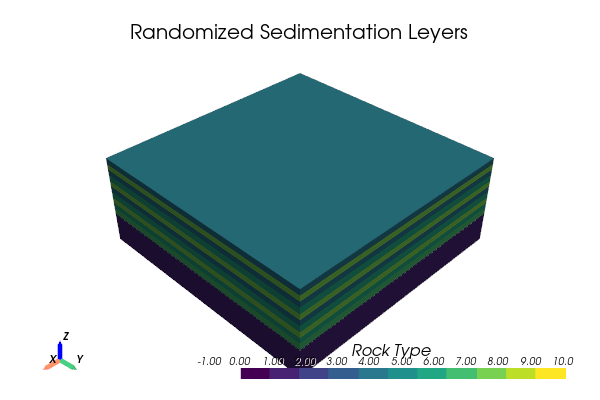

In [5]:
from structgeo.probability.random import NonRepeatingRandomListSelector

# Create a list of values that represent different types of sedimentary rocks.
sediment_rock_types = list(range(4,9))
# Shuffle the list in place
np.random.shuffle(sediment_rock_types)

sediment1 = geo.Sedimentation(height=5, value_list=sediment_rock_types, value_selector=NonRepeatingRandomListSelector)
model.clear_history()
model.add_history(bedrock)
model.add_history(sediment1)
model.compute_model()
p3 = geovis.volview(model)
p3.window_size = window_size
p3.add_title(title='Randomized Sedimentation Leyers', font_size=8)
p3.show()

To control the thickness of each layer, a generator function can be passed. The generator function should be a callable with no argument that returns a float. The generator will be called for each layer to determine the thickness of that layer.

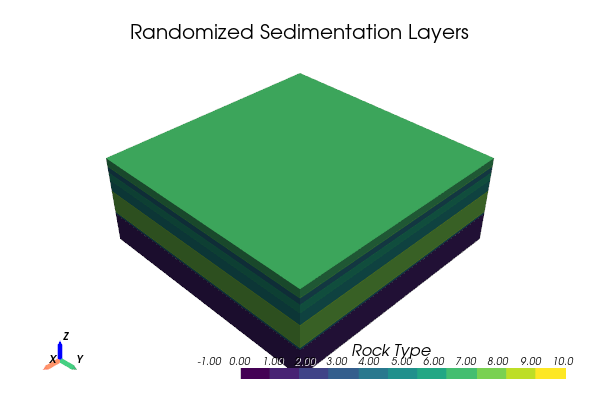

In [6]:
sediment2 = geo.Sedimentation(height=5, 
                              value_list=sediment_rock_types, 
                              value_selector=NonRepeatingRandomListSelector, 
                              thickness_callable = lambda: np.random.lognormal(.5,.5))
model.clear_history()
model.add_history(bedrock)
model.add_history(sediment2)
model.compute_model()
p3 = geovis.volview(model)
p3.window_size = window_size
p3.add_title(title='Randomized Sedimentation Layers', font_size=8)
p3.show()

### Dikes
A Dike is a planar intrusion of other rocktype into the model. Due to gravity, we expect dikes to fill in a fissure in the rock without extending into the air. This can be accomplished by specifying that the dike replaces existing rock only.

The strike angle is clockwise from north using the local coordinates origin specified by the origin parameter. The dip angle is how steep the dike is from the horizontal plane. The width is the thickness of the dike. The value is the rocktype


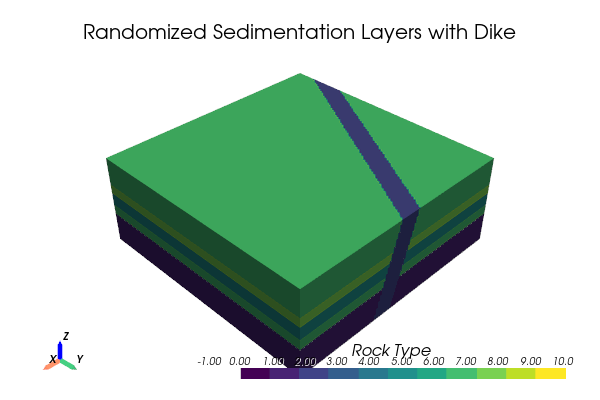

In [7]:
dike  = geo.Dike(strike=30, dip=75, width=3, origin=(-6, 8, 0), value=2)

history = [bedrock, sediment2, dike]
model.clear_history()
model.add_history(history)
model.compute_model()
p = geovis.volview(model)
p.window_size = window_size
p.add_title(title='Randomized Sedimentation Layers with Dike', font_size=8)
p.show()

### Tilt
Tilt is a simple transformation that tilts the model using the standard strike, dip, and origin prarameters. This specifies the plane of rotation for the tilt. 

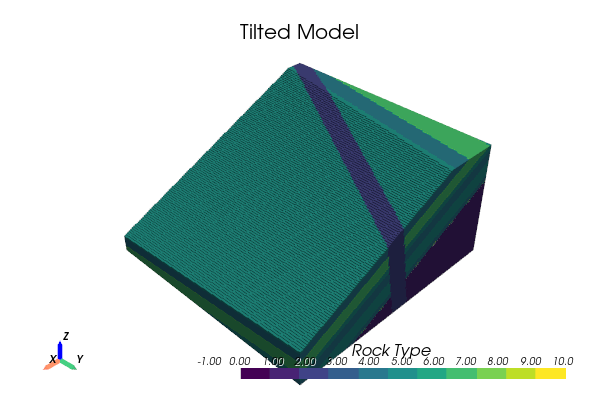

In [8]:
# Tilting axis laid down at edge of model (20) and tilted 15 degrees
tilt = geo.Tilt(strike=10, dip=25, origin=(0, 20, 0))
history = [bedrock, sediment2, dike, tilt]
model.clear_history()
model.add_history(history)
model.compute_model()
p = geovis.volview(model)
p.window_size = window_size
p.add_title(title='Tilted Model', font_size=8)
p.show()

### Deposition ontop of a model
The model lost some of the rock material that makes it interesting from the tilt. We can redeposit sediment on the layers, in the gravity orientation of the the new tilted field. Notice the dike is buried by the new sediment.

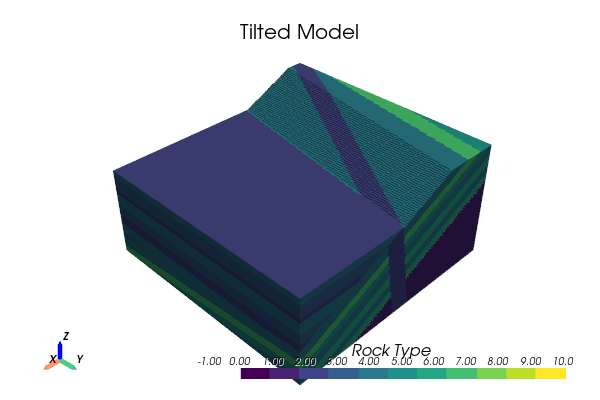

In [9]:
sediment3 = geo.Sedimentation(height=5.5, value_list = [2,3,4], thickness_callable = lambda: np.random.lognormal(.5,.5))
history = [bedrock, sediment2, dike, tilt, sediment3]
model.clear_history()
model.add_history(history)
model.compute_model()
p = geovis.volview(model)
p.window_size = window_size
p.add_title(title='Tilted Model', font_size=8)
p.show()

### Folding
Folding is one of the more complex transformations. The plane is defined by strike and dip and the fold direction/polarization is further defined by rake. It can be viewed as a wave with a direction normal to the plane and a polarization given by rake.

The default behaviour has a sinusiod with period and a shape parameter that can further alter the shape overall with a harmonic sinusoid. The tuning parameters for the wave form are period, amplitude, shape, and phase is set by origin.

Optionally a user defined function that accepts an array of n_cycles (number of periods from the strike plane) and returns an array of displacements can be passed. This replaces the default sinusoidal wave form.

#### Strike, Dip, Rake
The two angles form the plane of the plane-wave. The polarization vector of the wave is defined by the rake angle 0 is wave motion up and down, 90 is wave motion left to right. A demonstration of the polarization effect is shown below. Note that strike 90 is East-West and so the wave travels North-South.

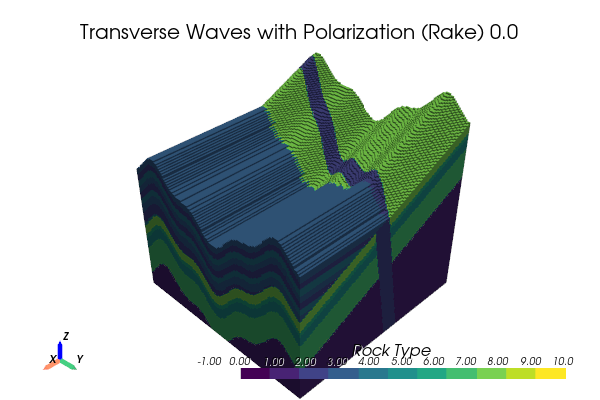

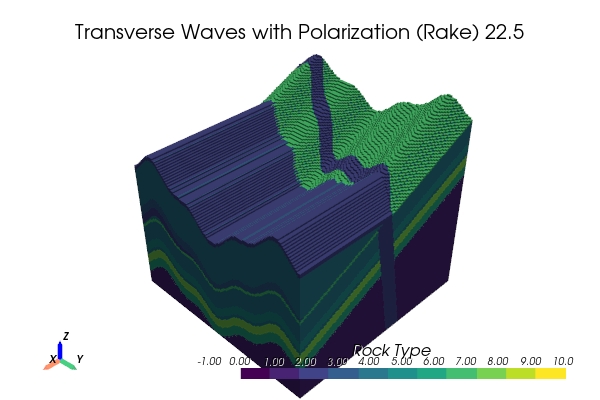

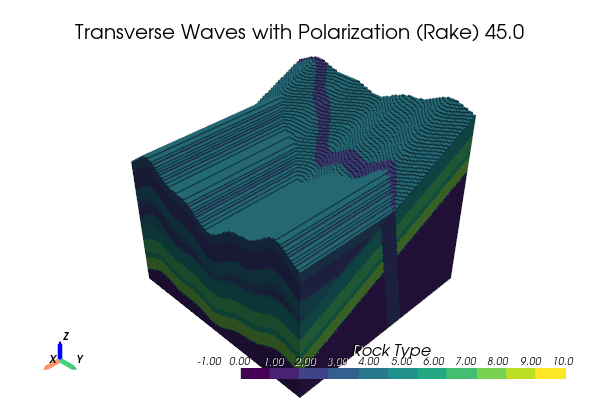

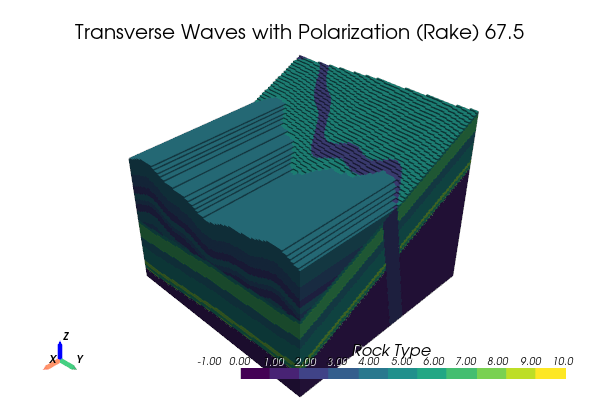

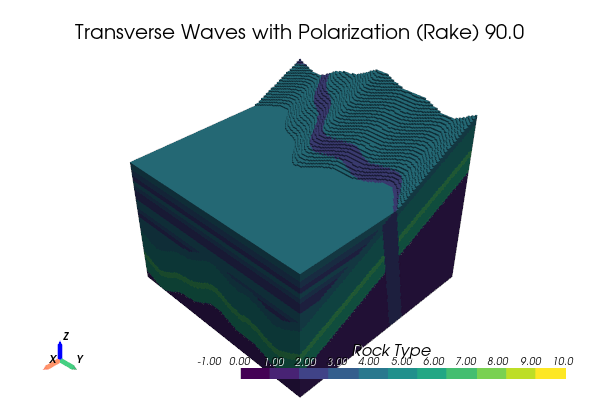

In [10]:
# Define the number of steps (including the end points)
num_steps = 5
# Generate rake values from 0 to 90 degrees, inclusively
rake_values = np.linspace(0, 90, num_steps)

for rake in rake_values:
    fold = geo.Fold(strike=90, dip=90, rake=rake, origin=(0, 0, 0), amplitude=4, period=30, shape=.3)
    history = [bedrock, sediment2, dike, tilt, sediment3, fold]
    # make a new larger model
    bounds = ((-20, 20), (-20, 20), (-20, 20))
    model = geo.GeoModel(bounds=bounds, resolution=128)
    model.clear_history()
    model.add_history(history)
    model.compute_model()
    p = geovis.volview(model)
    p.window_size = window_size
    p.add_title(title=f'Transverse Waves with Polarization (Rake) {rake}', font_size=8)
    p.show()


#### Dipping Effect
With 0 dip the folding effect is vertical instead of transverse which is hard to see without vertical layers.

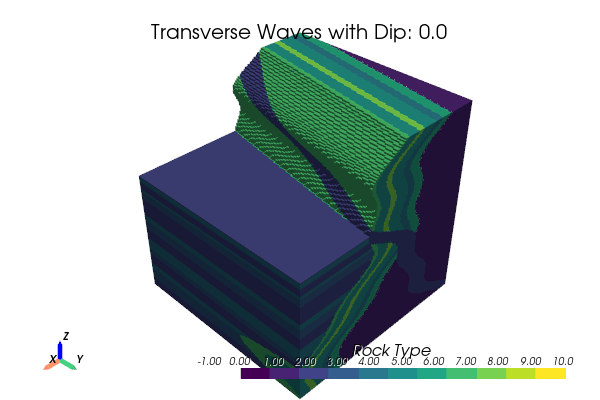

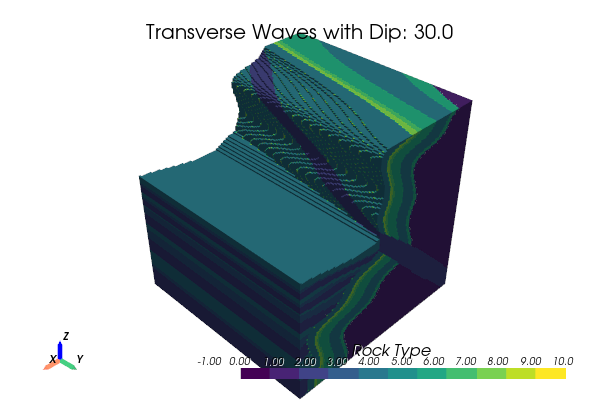

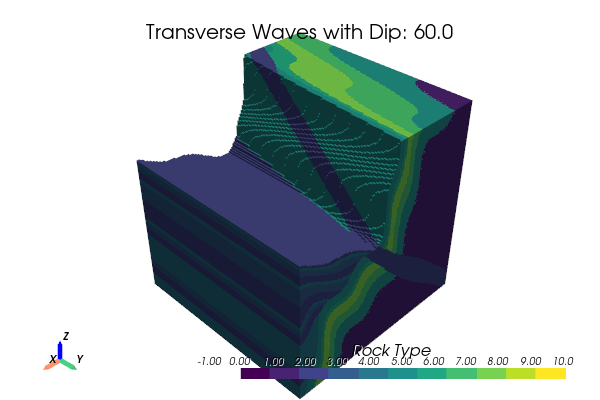

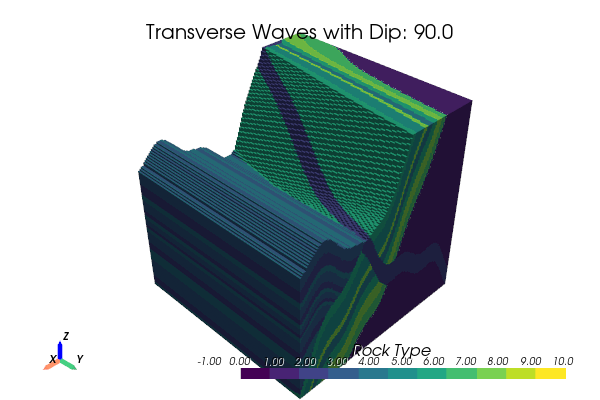

In [11]:
# Define the number of steps (including the end points)
num_steps = 4
# Generate rake values from 0 to 90 degrees, inclusively
dip_values = np.linspace(0, 90, num_steps)

for dip in dip_values:
    fold = geo.Fold(strike=0, dip=dip, rake=0, origin=(0, 0, 0), amplitude=4, period=30, shape=.3)
    tilt = geo.Tilt(strike=10, dip=25, origin=(0, 20, 0))
    tilt2 = geo.Tilt(strike=10, dip=60, origin=(0, 5, 0))
    history = [bedrock, sediment2, dike, tilt2, sediment3, fold]
    # make a new larger model
    bounds = ((-20, 20), (-20, 20), (-20, 20))
    model = geo.GeoModel(bounds=bounds, resolution=128)
    model.clear_history()
    model.add_history(history)
    model.compute_model()
    p = geovis.volview(model)
    p.window_size = window_size
    p.add_title(title=f'Transverse Waves with Dip: {dip}', font_size=8)
    p.show()

#### Custom Waveform
A custom waveform can be passed to the fold process. This is a function that accepts an array of n_cycles (number of periods from the strike plane) and returns an array of displacements. This can be used to create more complex folding patterns.

The wave form is still controlled by the period and amplitude arguments, the waveform does not need to be periodic, but one period or cycle maps to a value of 1.0 in the waveform function.

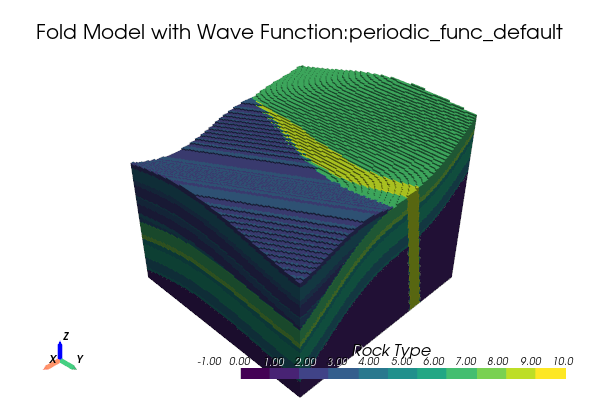

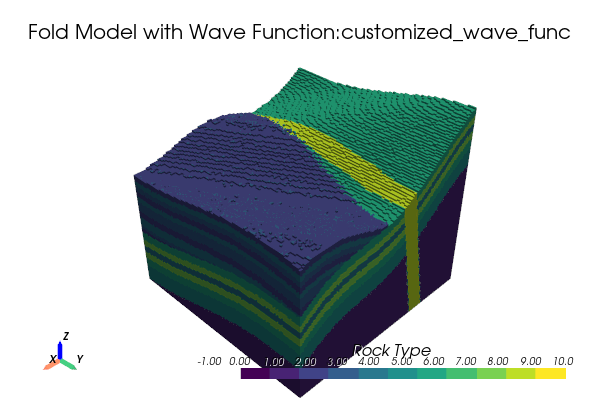

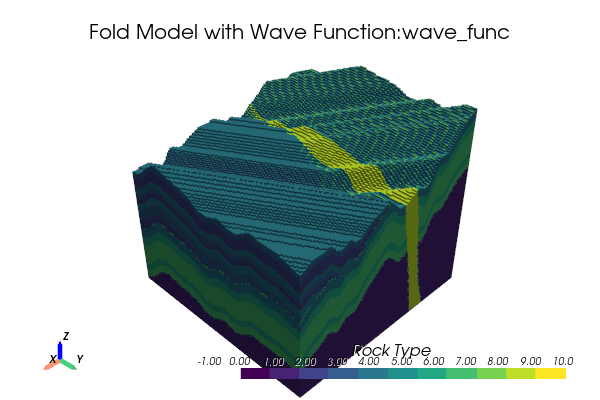

In [26]:
from structgeo.probability.random import noisy_sine_wave, fourier_series_wave

periodic_funcs = [None, noisy_sine_wave(1, 20, 0.3), fourier_series_wave(num_harmonics=10)]

for fun in periodic_funcs:
    # Period and amplitude modulate the passed function
    fold2 = geo.Fold(strike=150, dip=90, rake=10, origin=(0, 0, 0), amplitude=2, period=30, periodic_func=fun)
    history = [bedrock, sediment2, dike, tilt, sediment3, fold2]
    # make a new larger model
    bounds = ((-20, 20), (-20, 20), (-20, 20))
    model = geo.GeoModel(bounds=bounds, resolution=128)
    model.clear_history()
    model.add_history(history)
    model.compute_model()
    p = geovis.volview(model)
    p.window_size = window_size
    p.add_title(title=f'Fold Model with Wave Function:{fold2.periodic_func.__name__}', font_size=8)
    p.show()

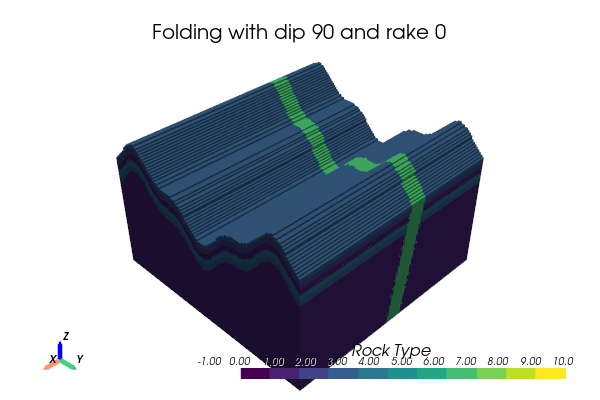

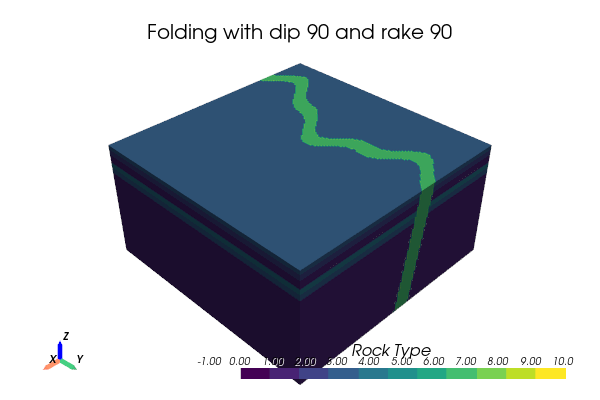

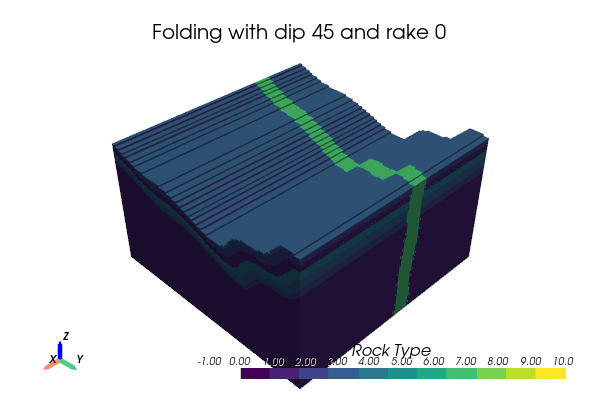

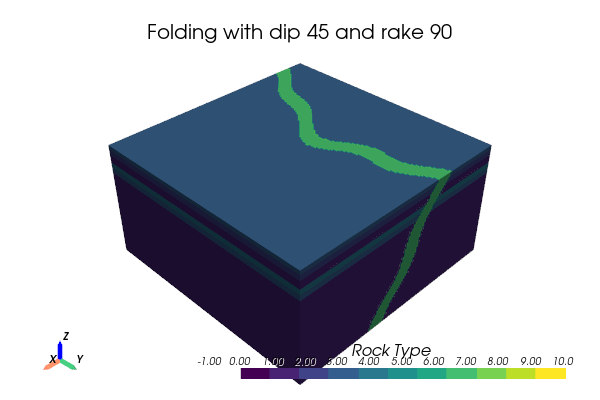

In [13]:

# Strike controls wave propogation compass direction
# Dip controls wave propogation angle from vertical
# Rake 90 = lateral polarization, Rake 0 = vertical polarization
strike_dip_rake = [(90, 90, 0), (90, 90, 90), (90, 45, 0), (90, 45, 90)]

for params in strike_dip_rake:    
    dike  = geo.Dike(strike=10, dip=80, width=3, origin=(-6, 8, 0), value=7)
    # Make a wave traveling North (y-direction) with lateral polarizaiton (rake 90)
    fold = geo.Fold(*params, origin=(0, 0, 0), amplitude=4, period=30, shape=.3)
    history = [bedrock, sediment0, dike, fold]

    model.clear_history()
    model.add_history(history)
    model.compute_model()
    p = geovis.volview(model)
    p.window_size = window_size
    p.add_title(title=f'Folding with dip {params[1]} and rake {params[2]}', font_size=8)
    p.show(jupyter_backend='static')

### Slips
Slips are a generalized type of transform that involves two layers slipping in either direction. This can be a brittle fracture such as found in a fault, or it can be a shear from in a ductile zone.

Slips are modeled as a function of displacement in the direction of the slip vector, a direction that is parallel to the fault plane and determined by the strike and dip and rake of the the feature.

For Faults the displacement is abrupt, modeled as a step function with a displacement vector. Shear is a plastic deformation modeled using a sigmoid function for a continuous deformation, with steepness controlled by the steepness parameter.

The rake is measured from the strike vector by convention, so unlike folds, lateral motion is given by a rake of 0 or 180 degrees. 

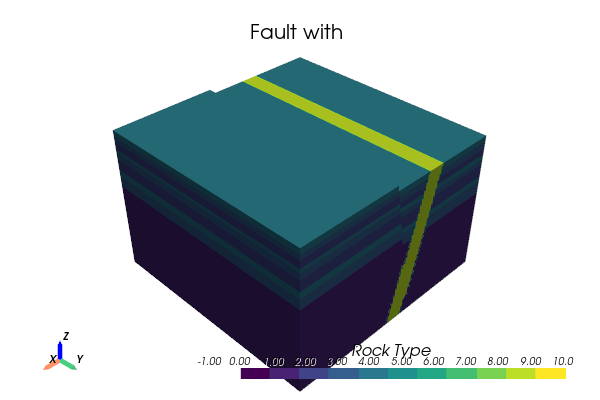

In [27]:
# strike_dip_rake = [(60, 90, 0), (0, 90, 90), (0, 45, 0), (0, 45, 90)]

fault = geo.Fault(strike=0, dip=80, rake=5, amplitude=2.5, origin=(0, 0, 0))
dike  = geo.Dike(strike=0, dip=75, width=3, origin=(-6, 8, 0), value=9)
history = [bedrock, sediment3, dike, fault]
# make a new larger model
bounds = ((-20, 20), (-20, 20), (-20, 20))
model = geo.GeoModel(bounds=bounds, resolution=128)
model.clear_history()
model.add_history(history)
model.compute_model()
p = geovis.volview(model)
p.window_size = window_size
p.add_title(title='Fault with ', font_size=8)
p.show()